# baseline v3

이 베이스라인 코드는 `사전학습 모델 로드`, `배치 학습`, `파인튜닝`, `양자화`, `PEFT` 등이 적용된 버전입니다.

Colab의 GPU 환경에서 개발되었습니다.
- 런타임 - 런타임 유형 변경 - GPU로 변경(T4 GPU 등)



# 환경 준비

개발 환경에 필요한 라이브러리 버전을 고정하고 최신 버전으로 라이브러리를 업데이트합니다.

- 아래 셀 실행
- 실행 완료 후 런타임 - 세션 다시 시작

In [1]:
!pip -q install "transformers>=4.44.2" "accelerate>=0.34.2" "peft>=0.13.2" "bitsandbytes>=0.43.1" datasets pillow pandas torch torchvision --upgrade

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 91.2/91.2 kB 6.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.1/60.1 MB 10.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 506.3/506.3 kB 21.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.0/7.0 MB 56.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.4/12.4 MB 64.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 899.7/899.7 MB 1.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 594.3/594.3 MB 2.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.2/10.2 MB 91.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 88.0/88.0 MB 8.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 954.8/954.8 kB 27.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 193.1/193.1 MB 6.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 29.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.6/

# 데이터 준비

개발에 필요한 데이터를 준비합니다.

- train.csv, train 폴더
- test.csv, test 폴더
- sample_submission.csv

본 베이스라인은 colab에서 구글 드라이브를 마운트하여 사용합니다.

데이터를 압축 해제하는데 몇 분 정도의 시간이 소요됩니다.

#### 실습 참고 내용

    챕터 2-2 합성 데이터 실습
    - 구글 드라이브 마운트 : drive()

In [1]:
# 구글드라이브 마운트
from google.colab import drive
drive.mount('/content')

Mounted at /content/drive


In [5]:
# 압축 해제
!unzip "/content/data.zip" -d "/content/"

스트리밍 출력 내용이 길어서 마지막 5000줄이 삭제되었습니다.
  inflating: /content/test/test_2776.jpg  
  inflating: /content/test/test_2777.jpg  
  inflating: /content/test/test_2778.jpg  
  inflating: /content/test/test_2779.jpg  
  inflating: /content/test/test_2780.jpg  
  inflating: /content/test/test_2781.jpg  
  inflating: /content/test/test_2782.jpg  
  inflating: /content/test/test_2783.jpg  
  inflating: /content/test/test_2784.jpg  
  inflating: /content/test/test_2785.jpg  
  inflating: /content/test/test_2786.jpg  
  inflating: /content/test/test_2787.jpg  
  inflating: /content/test/test_2788.jpg  
  inflating: /content/test/test_2789.jpg  
  inflating: /content/test/test_2790.jpg  
  inflating: /content/test/test_2791.jpg  
  inflating: /content/test/test_2792.jpg  
  inflating: /content/test/test_2793.jpg  
  inflating: /content/test/test_2794.jpg  
  inflating: /content/test/test_2795.jpg  
  inflating: /content/test/test_2796.jpg  
  inflating: /content/test/test_2797.jpg  
  inflating: /cont

# 라이브러리, 데이터, 설정

In [6]:
import os, re, math, random
import pandas as pd
from PIL import Image
from torch.utils.data import Dataset, DataLoader
from dataclasses import dataclass
import torch
from typing import Dict, List, Any
from transformers import (
    AutoModelForVision2Seq,
    AutoProcessor,
    BitsAndBytesConfig,
    get_linear_schedule_with_warmup
)
from peft import LoraConfig, get_peft_model, prepare_model_for_kbit_training
from tqdm import tqdm

# 이미지 로드 시 픽셀 제한 해제
Image.MAX_IMAGE_PIXELS = None

# 디바이스 GPU 우선 사용 설정
device = "cuda" if torch.cuda.is_available() else "cpu"
print("Device:", device)

# 사전 학습 모델 정의
MODEL_ID = "Qwen/Qwen2.5-VL-3B-Instruct"
IMAGE_SIZE = 384
MAX_NEW_TOKENS = 8
SEED = 42
random.seed(SEED); torch.manual_seed(SEED); torch.cuda.manual_seed_all(SEED)

# 데이터셋 로드
train_df = pd.read_csv("/content/train.csv")
test_df  = pd.read_csv("/content/test.csv")

# 학습데이터 200개만 추출
train_df = train_df.sample(n=200, random_state=SEED).reset_index(drop=True)

Device: cuda


# 모델, Processor

7.5GB 정도의 모델 다운로드가 진행됩니다. 10~20분 정도가 소요됩니다.

#### 실습 참고 내용

    챕터 5-1 PEFT(파라미터 효율적 튜닝)
    - LoRA 구현 : LoraConfig()

In [7]:
# 양자화
bnb_config = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_use_double_quant=True,
    bnb_4bit_quant_type="nf4",
    bnb_4bit_compute_dtype=torch.float16,
)

# 프로세서
processor = AutoProcessor.from_pretrained(
    MODEL_ID,
    min_pixels=IMAGE_SIZE*IMAGE_SIZE,
    max_pixels=IMAGE_SIZE*IMAGE_SIZE,
    trust_remote_code=True,
)

# 사전학습 모델
base_model = AutoModelForVision2Seq.from_pretrained(
    MODEL_ID,
    quantization_config=bnb_config,
    device_map="auto",
    trust_remote_code=True,
)

# 양자화 모델로 로드
base_model = prepare_model_for_kbit_training(base_model)
base_model.gradient_checkpointing_enable()

# LoRA 세팅
lora_config = LoraConfig(
    r=8,
    lora_alpha=16,
    lora_dropout=0.05,
    bias="none",
    target_modules=["q_proj","k_proj","v_proj","o_proj","gate_proj","up_proj","down_proj"],
    task_type="CAUSAL_LM",
)

# PEFT 모델 생성
model = get_peft_model(base_model, lora_config)
model.print_trainable_parameters()

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


preprocessor_config.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

The image processor of type `Qwen2VLImageProcessor` is now loaded as a fast processor by default, even if the model checkpoint was saved with a slow processor. This is a breaking change and may produce slightly different outputs. To continue using the slow processor, instantiate this class with `use_fast=False`. Note that this behavior will be extended to all models in a future release.


tokenizer_config.json: 0.00B [00:00, ?B/s]

vocab.json: 0.00B [00:00, ?B/s]

merges.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

chat_template.json: 0.00B [00:00, ?B/s]

/usr/local/lib/python3.12/dist-packages/transformers/models/auto/modeling_auto.py:2284: FutureWarning: The class `AutoModelForVision2Seq` is deprecated and will be removed in v5.0. Please use `AutoModelForImageTextToText` instead.
  warnings.warn(


config.json: 0.00B [00:00, ?B/s]

model.safetensors.index.json: 0.00B [00:00, ?B/s]

Fetching 2 files:   0%|          | 0/2 [00:00<?, ?it/s]

model-00002-of-00002.safetensors:   0%|          | 0.00/3.53G [00:00<?, ?B/s]

model-00001-of-00002.safetensors:   0%|          | 0.00/3.98G [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/216 [00:00<?, ?B/s]

trainable params: 18,576,384 || all params: 3,773,199,360 || trainable%: 0.4923


# 프롬프트 템플릿

#### 실습 참고 내용

    챕터 5-1 PEFT(파라미터 효율적 튜닝)
    - 프롬프트 템플릿 : convert_to_chatml(), formatting_prompts_func()

In [8]:
# 모델 지시사항
SYSTEM_INSTRUCT = (
    "You are a helpful visual question answering assistant. "
    "Answer using exactly one letter among a, b, c, or d. No explanation."
)

# 프롬프트
def build_mc_prompt(question, a, b, c, d):
    return (
        f"{question}\n"
        f"(a) {a}\n(b) {b}\n(c) {c}\n(d) {d}\n\n"
        "정답을 반드시 a, b, c, d 중 하나의 소문자 한 글자로만 출력하세요."
    )

# Custom Dataset, Collator

#### 실습 참고 내용

    챕터 1-2 MLP 구현
    - TensorDataset()

    챕터 5-2 데이터 생성 및 파인튜닝 (향후 학습 분량)
    - IntentDataset()

In [9]:
# 커스텀 데이터셋
class VQAMCDataset(Dataset):
    def __init__(self, df, processor, train=True):
        self.df = df.reset_index(drop=True)
        self.processor = processor
        self.train = train

    def __len__(self): return len(self.df)

    def __getitem__(self, i):
        row = self.df.iloc[i]
        img = Image.open(row["path"]).convert("RGB")

        q = str(row["question"])
        a, b, c, d = str(row["a"]), str(row["b"]), str(row["c"]), str(row["d"])
        user_text = build_mc_prompt(q, a, b, c, d)

        messages = [
            {"role":"system","content":[{"type":"text","text":SYSTEM_INSTRUCT}]},
            {"role":"user","content":[
                {"type":"image","image":img},
                {"type":"text","text":user_text}
            ]}
        ]
        if self.train:
            gold = str(row["answer"]).strip().lower()
            messages.append({"role":"assistant","content":[{"type":"text","text":gold}]})

        return {"messages": messages, "image": img}

# 데이터 콜레이터
@dataclass
class DataCollator:
    processor: Any
    train: bool = True

    def __call__(self, batch):
        texts, images = [], []
        for sample in batch:
            messages = sample["messages"]
            img = sample["image"]

            text = self.processor.apply_chat_template(
                messages,
                tokenize=False,
                add_generation_prompt=False
            )
            texts.append(text)
            images.append(img)

        enc = self.processor(
            text=texts,
            images=images,
            padding=True,
            return_tensors="pt"
        )

        if self.train:
            enc["labels"] = enc["input_ids"].clone()

        return enc


# DataLoader

#### 실습 참고 내용

    챕터 3-1 Transfer Learning 기반의 CNN 모델 학습
    - 데이터로더 정의 : DataLoader()

In [10]:
# 검증용 데이터 분리
split = int(len(train_df)*0.9)
train_subset, valid_subset = train_df.iloc[:split], train_df.iloc[split:]

# VQAMCDataset 형태로 변환
train_ds = VQAMCDataset(train_subset, processor, train=True)
valid_ds = VQAMCDataset(valid_subset, processor, train=True)

# 데이터로더
train_loader = DataLoader(train_ds, batch_size=1, shuffle=True, collate_fn=DataCollator(processor, True), num_workers=0)
valid_loader = DataLoader(valid_ds, batch_size=1, shuffle=False, collate_fn=DataCollator(processor, True), num_workers=0)

# fine-tuning

- 200개만 학습 : 10~20분 소요

#### 실습 참고 내용

    챕터 1-2 MLP 구현
    - 모델 정의 : SimpleMLP(), SequentialMLP()

    챕터 3-1 Transfer Learning 기반의 CNN 모델 학습
    - 학습 루프 : 문제 6: 모델 학습을 위한 반복문
    - 추론 : with torch.no_grad(), model.eval()

In [11]:
from tqdm.auto import tqdm

model = model.to(device)
GRAD_ACCUM = 4

# 옵티마이저, 학습 스케줄러
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-4)
num_training_steps = 1 * math.ceil(len(train_loader)/GRAD_ACCUM)
scheduler = get_linear_schedule_with_warmup(optimizer, int(num_training_steps*0.03), num_training_steps)

# 스케일러
scaler = torch.cuda.amp.GradScaler(enabled=True)

# 학습 루프
global_step = 0
for epoch in range(1):
    running = 0.0
    progress_bar = tqdm(train_loader, desc=f"Epoch {epoch+1} [train]", unit="batch")
    for step, batch in enumerate(progress_bar, start=1):
        batch = {k:v.to(device) for k,v in batch.items()}
        with torch.cuda.amp.autocast(dtype=torch.bfloat16):
            outputs = model(**batch)
            loss = outputs.loss / GRAD_ACCUM

        scaler.scale(loss).backward()
        running += loss.item()

        if step % GRAD_ACCUM == 0:
            scaler.step(optimizer)
            scaler.update()
            optimizer.zero_grad(set_to_none=True)
            scheduler.step()
            global_step += 1

            avg_loss = running / GRAD_ACCUM
            progress_bar.set_postfix({"loss": f"{avg_loss:.3f}"})
            running = 0.0

    model.eval()
    val_loss = 0.0
    val_steps = 0
    with torch.no_grad(), torch.cuda.amp.autocast(dtype=torch.bfloat16):
        for vb in tqdm(valid_loader, desc=f"Epoch {epoch+1} [valid]", unit="batch"):
            vb = {k:v.to(device) for k,v in vb.items()}
            val_loss += model(**vb).loss.item()
            val_steps += 1
    print(f"[Epoch {epoch+1}] valid loss {val_loss/val_steps:.4f}")
    model.train()

# 모델 저장
SAVE_DIR = "/content/qwen2_5_vl_3b_lora"
model.save_pretrained(SAVE_DIR)
processor.save_pretrained(SAVE_DIR)
print("Saved:", SAVE_DIR)


/tmp/ipython-input-3800637758.py:12: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler(enabled=True)


Epoch 1 [train]:   0%|          | 0/180 [00:00<?, ?batch/s]

/tmp/ipython-input-3800637758.py:21: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(dtype=torch.bfloat16):
/tmp/ipython-input-3800637758.py:42: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.no_grad(), torch.cuda.amp.autocast(dtype=torch.bfloat16):


Epoch 1 [valid]:   0%|          | 0/20 [00:00<?, ?batch/s]

[Epoch 1] valid loss 5.6597
Saved: /content/qwen2_5_vl_3b_lora


# inference

30분~1시간 소요

#### 실습 참고 내용

    챕터4-1 RAG 기반 Customer Service AI 에이전트 개발
    - 데이터 파서 : langchain_core.output_parsers(), StrOutputParser()

    챕터 3-1 Transfer Learning 기반의 CNN 모델 학습
    - 학습 루프 : 문제 6: 모델 학습을 위한 반복문
    - 추론 : with torch.no_grad(), model.eval()

In [12]:
# 데이터 파서 : 모델의 응답에서 선지를 추출
def extract_choice(text: str) -> str:
    text = text.strip().lower()

    lines = [l.strip() for l in text.splitlines() if l.strip()]
    if not lines:
        return "a"
    last = lines[-1]
    if last in ["a", "b", "c", "d"]:
        return last

    tokens = last.split()
    for tok in tokens:
        if tok in ["a", "b", "c", "d"]:
            return tok
    return "a"

# 추론을 위해 모든 레이어 활성화
model.eval()
preds = []

# 추론 루프
for i in tqdm(range(len(test_df)), desc="Inference", unit="sample"):
    row = test_df.iloc[i]
    img = Image.open(row["path"]).convert("RGB")
    user_text = build_mc_prompt(row["question"], row["a"], row["b"], row["c"], row["d"])

    messages = [
        {"role":"system","content":[{"type":"text","text":SYSTEM_INSTRUCT}]},
        {"role":"user","content":[
            {"type":"image","image":img},
            {"type":"text","text":user_text}
        ]}
    ]

    text = processor.apply_chat_template(messages, tokenize=False, add_generation_prompt=True)
    inputs = processor(text=[text], images=[img], return_tensors="pt").to(device)

    with torch.no_grad():
        out_ids = model.generate(**inputs, max_new_tokens=2, do_sample=False,
                                 eos_token_id=processor.tokenizer.eos_token_id)
    output_text = processor.batch_decode(out_ids, skip_special_tokens=True)[0]
    # print("output_text:", output_text)
    # print("extract_choice:", extract_choice(output_text))
    preds.append(extract_choice(output_text))

# 제출 파일 생성
submission = pd.DataFrame({"id": test_df["id"], "answer": preds})
submission.to_csv("/content/submission.csv", index=False)
print("Saved /content/submission.csv")

Inference:   0%|          | 0/3887 [00:00<?, ?sample/s]

The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


Saved /content/submission.csv


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [20]:
import pandas as pd

# Load the submission file
submission_df = pd.read_csv("/content/submission.csv")

# Load the sample submission file
sample_submission_df = pd.read_csv("/content/sample_submission.csv")

# Merge the two dataframes to compare the answers
comparison_df = pd.merge(submission_df, sample_submission_df, on="id", suffixes=("_predicted", "_sample"))

# Calculate the accuracy
correct_predictions = (comparison_df["answer_predicted"] == comparison_df["answer_sample"]).sum()
total_predictions = len(comparison_df)
accuracy = correct_predictions / total_predictions

print(f"Accuracy: {accuracy:.4f}")

# Display the comparison dataframe (optional)
# display(comparison_df.head())

Accuracy: 0.0000


system
You are a helpful visual question answering assistant. Answer using exactly one letter among a, b, c, or d. No explanation.
user
이 사진의 주요 상황은 무엇인가요?
(a) 수업 시간에 공부하고 있다
(b) 회의에 참석하고 있다
(c) 졸업식 준비 중이다
(d) 시험을 치르고 있다

정답을 반드시 a, b, c, d 중 하나의 소문자 한 글자로만 출력하세요.
assistant
c


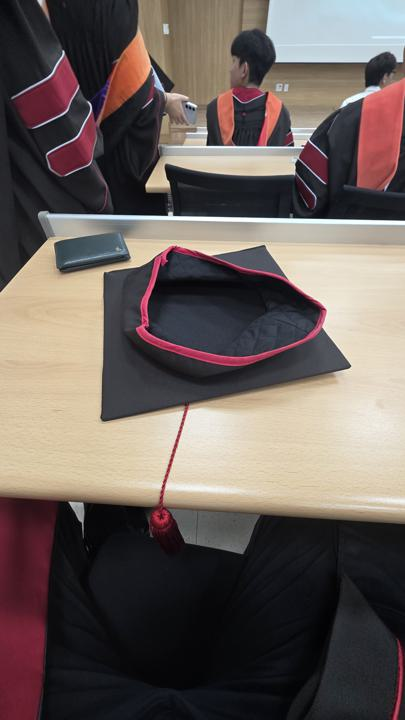

In [19]:
# 모델 응답 예시
print(output_text)

In [15]:
torch.save(model.state_dict(), '/content/drive/MyDrive/checkpoint.pth')

In [16]:
with open('/content/drive/MyDrive/log.txt', 'a') as f:
    f.write("step 100 | loss 0.234\n")